## setup

In [173]:
! pip install tensorflow numpy matplotlib pandas scikit-learn opencv-python

import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import tensorflow as tf
import keras
from keras import Input, Model
from keras.layers import Conv2D, Concatenate, Flatten, Dense, MaxPooling2D
import keras.optimizers
import sklearn
import sklearn.metrics
from PIL import Image

In [174]:
# Transformation helper functions

import cv2
import numpy as np
import matplotlib.pyplot as plt

def transform_projection(image, rotation, shift, scale):
    image = image.astype(np.float32)

    h, w = image.shape[:2]

    # ---- Parameters ----
    shift_x, shift_y = shift     # pixels
    rot_x, rot_y, rot_z = rotation   # degrees of 3D rotation

    # ---- Build Projection Matrix ----
    f = 500
    cx, cy = w//2, h//2

    

    # Define corner points in 3D
    corners_3d = np.array([
        [-w/2, -h/2, 0],
        [ w/2, -h/2, 0],
        [ w/2,  h/2, 0],
        [-w/2,  h/2, 0]
    ], dtype=np.float32)

    # Apply rotation
    R = rotation_matrix(rot_x, rot_y, rot_z)
    rotated = corners_3d @ R.T

    # Apply scaling
    rotated *= scale

    # Project back to 2D
    projected = rotated.copy()
    projected[:,0] = f * projected[:,0] / (f + projected[:,2]) + cx + shift_x
    projected[:,1] = f * projected[:,1] / (f + projected[:,2]) + cy + shift_y

    # Warp perspective
    src_pts = np.array([[0,0],[w,0],[w,h],[0,h]], dtype=np.float32)
    dst_pts = projected[:,:2].astype(np.float32)
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    output = cv2.warpPerspective(image, M, (w+200, h+200))
    return np.clip(output, 0.0, 1.0).astype(np.float32)

def rotation_matrix(rx, ry, rz):
        rx, ry, rz = np.deg2rad([rx, ry, rz])
        Rx = np.array([[1, 0, 0],
                    [0, np.cos(rx), -np.sin(rx)],
                    [0, np.sin(rx),  np.cos(rx)]])
        Ry = np.array([[ np.cos(ry), 0, np.sin(ry)],
                    [0, 1, 0],
                    [-np.sin(ry), 0, np.cos(ry)]])
        Rz = np.array([[np.cos(rz), -np.sin(rz), 0],
                    [np.sin(rz),  np.cos(rz), 0],
                    [0, 0, 1]])
        return Rz @ Ry @ Rx 


# Create & Transform Texture

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from random import randint


def to_float32_unit(image):
    image = np.asarray(image, dtype=np.float32)
    if image.max() > 1.0 or image.min() < 0.0:
        image /= 255.0
    return np.clip(image, 0.0, 1.0).astype(np.float32)


def generateTransformedTex(
    textureStyle = 'noise',
    textureRepeated = False,
    textureResolution = 32,
    textureRandomSeed = 32,
    rotation = (0, 20, 45),
    shift = (40, 40),
    scale = 2.2
):
    


    if textureStyle == 'noise':
        texture = np.random.rand(textureResolution, textureResolution, 3).astype(np.float32)
    elif textureStyle == 'mud':
        texture = to_float32_unit(
            Image.open('textures/mud.png').convert('RGB').resize((100, 100), resample=Image.NEAREST)
        )
    elif textureStyle == 'snow':
        texture = to_float32_unit(
            Image.open('textures/snow.png').convert('RGB').resize((100, 100), resample=Image.NEAREST)
        )
    else:
        raise ValueError(f"Unsupported texture style '{textureStyle}'")


    if textureRepeated and textureStyle == 'noise':
        tile_rows = 500 // texture.shape[0] + 1
        tile_cols = 500 // texture.shape[1] + 1
        tiled_texture = np.tile(texture, (tile_rows, tile_cols, 1))[:500, :500, :]
    elif textureRepeated and textureStyle != 'noise':
        canvas = np.zeros((500, 500, 3), dtype=np.float32)
        tex_h, tex_w = texture.shape[:2]

        np.random.seed(textureRandomSeed)  # For reproducibility

        for y in range(0, 500, tex_h):
            for x in range(0, 500, tex_w):
                y0 = np.clip(y + np.random.randint(-tex_h//4, tex_h//4), 0, 500 - tex_h)
                x0 = np.clip(x + np.random.randint(-tex_w//4, tex_w//4), 0, 500 - tex_w)
                y_end = y0 + tex_h
                x_end = x0 + tex_w

                patch = texture.copy()
                if np.random.rand() < 0.5:
                    patch = np.flipud(patch)
                if np.random.rand() < 0.5:
                    patch = np.fliplr(patch)

                canvas[y0:y_end, x0:x_end] = patch

        tiled_texture = canvas
    else:  # if not repeated, resize it
        tiled_texture = cv2.resize(texture, (500, 500), interpolation=cv2.INTER_NEAREST)


    tiled_texture = to_float32_unit(tiled_texture)



    transformed_tex_unsized = transform_projection(tiled_texture, rotation, shift, scale = scale)
    transformed_tex = cv2.resize(
        transformed_tex_unsized, (500, 500), interpolation=cv2.INTER_NEAREST
    )
    transformed_tex = np.clip(transformed_tex, 0.0, 1.0).astype(np.float32)


    return transformed_tex


In [176]:
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = keras.preprocessing.image.load_img(path, target_size=image_size)
        img = keras.preprocessing.image.img_to_array(img).astype(np.float32)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images, dtype=np.float32)

print("Loading validation datasets...")
val_x_ref = load_images_from_folder('validation_dataset_clean/reference')
val_eta_exp = load_images_from_folder('validation_dataset_clean/texture')
val_x_ren = load_images_from_folder('validation_dataset_clean/rendered')

Loading validation datasets...


In [178]:
transformed_tex = generateTransformedTex(
    textureStyle = 'noise',
    textureRepeated = False,
    textureResolution = 32,
    textureRandomSeed = 32,
    rotation = (0, 20, 45),
    shift = (40, 40),
    scale = 2.2
)

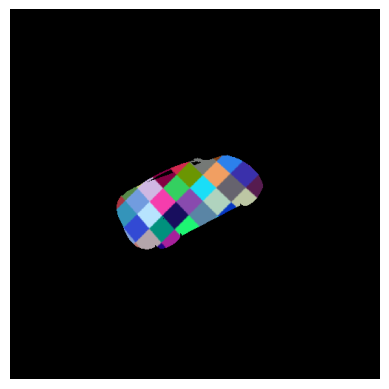

In [179]:
mask = np.any(val_eta_exp[65] > 0.01, axis=-1, keepdims=True)  # Shape: (500, 500, 1)

# Apply texture to masked regions
texture_mask = np.where(mask, transformed_tex, np.zeros_like(transformed_tex))

plt.imshow(texture_mask)
plt.axis('off')
plt.show()


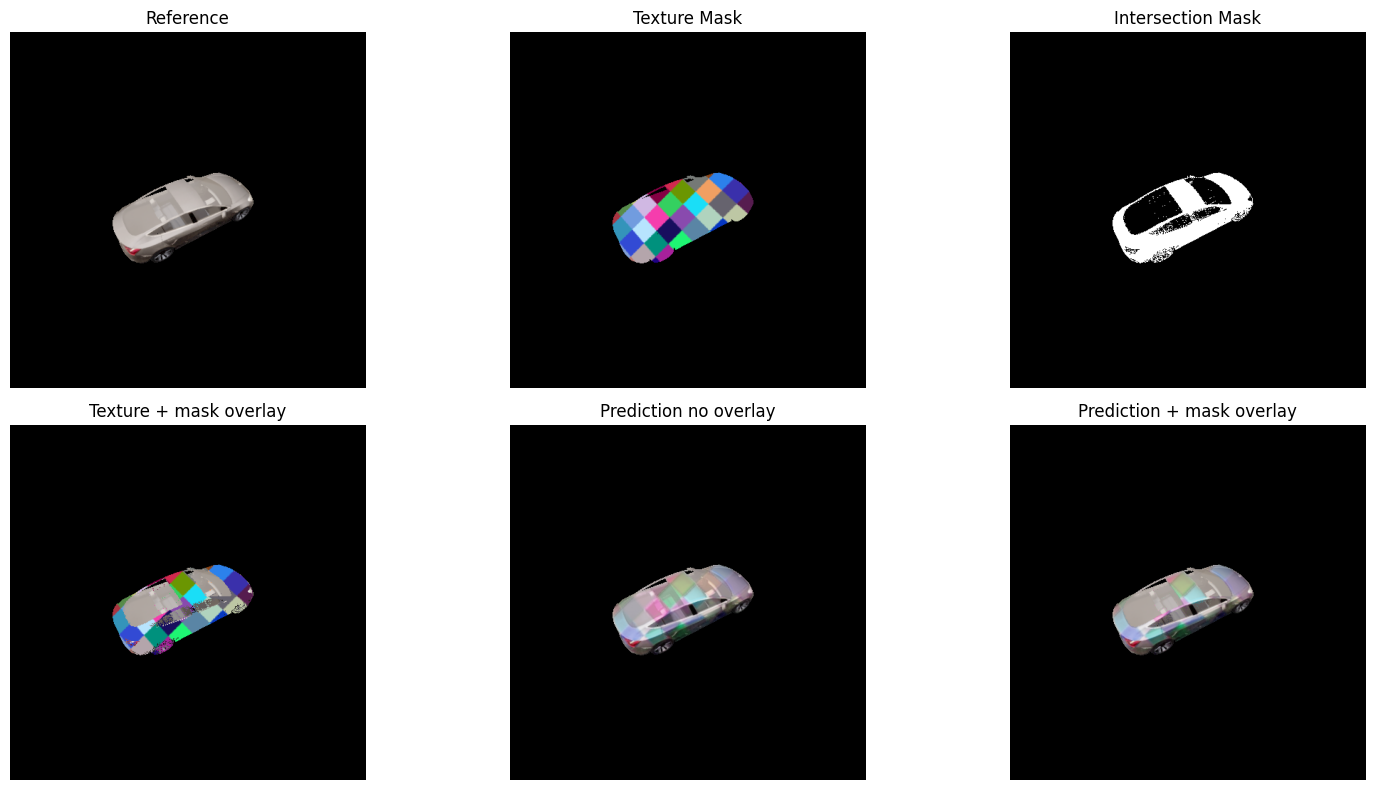

In [183]:
def predict_and_display(model, ref, tex, cross_ref):
    outputs = model.predict([ref, tex])
    pred = outputs[0].astype(np.float32)

    # Compute intersection (where rendered and reference are nearly equal)
    intersection_mask = np.isclose(cross_ref, ref, atol=1e-2).all(axis=-1, keepdims=True)

    # Overlay: only keep intersecting pixels in prediction
    overlay_preds = np.where(intersection_mask, ref, pred)

    def _imshow(ax, image, title, cmap=None):
        ax.set_title(title)
        if cmap:
            ax.imshow(image, cmap=cmap)
        else:
            ax.imshow(np.clip(image, 0.0, 1.0))
        ax.axis("off")

    fig = plt.figure(figsize=(16, 8))

    _imshow(fig.add_subplot(2, 3, 1), ref[0], "Reference")

    _imshow(fig.add_subplot(2, 3, 2), tex[0], "Texture Mask")

    _imshow(
        fig.add_subplot(2, 3, 3),
        1.0 - intersection_mask[0, :, :, 0].astype(np.float32),
        "Intersection Mask",
        cmap="gray",
    )

    tex_overlay = np.where(intersection_mask, ref, tex)
    _imshow(fig.add_subplot(2, 3, 4), tex_overlay[0], "Texture + mask overlay")

    _imshow(fig.add_subplot(2, 3, 5), pred, "Prediction no overlay")

    _imshow(fig.add_subplot(2, 3, 6), overlay_preds[0], "Prediction + mask overlay")

    plt.tight_layout()
    plt.show()





model = keras.models.load_model('models/k3_100epch_wo_custom_loss_model.h5', compile=False)

refInput = np.expand_dims(val_x_ref[65], axis=0).astype(np.float32)  # shape: (1, 500, 500, 3)
texInput = np.expand_dims(texture_mask, axis=0).astype(np.float32)  # shape: (1, 500, 500, 3)
cross_ref = np.expand_dims(val_x_ren[65], axis=0).astype(np.float32)  # shape: (1, 500, 500, 3)

predict_and_display(model, refInput, texInput, cross_ref)


In [ ]:
# MAYBE RE-TRAIN MODELS WITH LESS NODES? COLOURISARION ISSUES

# Playground

In [ ]:


imageNo = 65
modelChoice = 'k3_100epch_wo_custom_loss_model.h5'
textureStyle = 'noise'
textureRepeated = False
textureResolution = 32
textureRandomSeed = 32
rotation = (0, 20, 45)
shift = (40, 40)
scale = 2.2 # scale = 1.0 --> no scaling


